## Imports and functions

In [1]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time

In [2]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from frank2d import Frank2D 
from constants import rad_to_arcsec
from plot import Plot
from fit import ConjugateGradientMethod

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter

from scipy.sparse.linalg._interface import LinearOperator
from scipy.sparse.linalg._isolve.utils import make_system

In [3]:
def deproject(u, v, inc, PA, inverse=False):
    r"""
    Deproject the image in visibily space

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    inc : float, unit = deg
        Inclination
    PA : float, unit = deg
        Position angle, defined east of north.
    inverse : bool, default=False
        If True, the uv-points are reprojected rather than deprojected

    Returns
    -------
    up : array, size = N, unit = :math:`\lambda`
        Deprojected u-points
    vp : array, size = N, unit = :math:`\lambda`
        Deprojected v-points
    wp : array of real, size = N, unit = :math:`\lambda`
        Fourier w-points of the deprojected visibilities. Only returned if
        deprojecting.

    """
    deg_to_rad = np.pi / 180
    inc *= deg_to_rad
    PA *= deg_to_rad

    cos_t = np.cos(PA)
    sin_t = np.sin(PA)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp, wp

## Upload input

In [4]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 1.9 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

ud, vd, _ = deproject(u, v, inc, pa)

### Source Code for CG

#### Inspect source code

In [7]:
def _get_atol_rtol(name, b_norm, atol=0., rtol=1e-5):
    """
    A helper function to handle tolerance normalization
    """
    if atol == 'legacy' or atol is None or atol < 0:
        msg = (f"'scipy.sparse.linalg.{name}' called with invalid `atol`={atol}; "
               "if set, `atol` must be a real, non-negative number.")
        raise ValueError(msg)

    atol = max(float(atol), float(rtol) * float(b_norm))

    return atol, rtol


In [8]:
def cg(A, b, x0=None, *, rtol=1e-5, atol=0., maxiter=None, M=None, callback=None):
    """Use Conjugate Gradient iteration to solve ``Ax = b``.

    Parameters
    ----------
    A : {sparse matrix, ndarray, LinearOperator}
        The real or complex N-by-N matrix of the linear system.
        ``A`` must represent a hermitian, positive definite matrix.
        Alternatively, ``A`` can be a linear operator which can
        produce ``Ax`` using, e.g.,
        ``scipy.sparse.linalg.LinearOperator``.
    b : ndarray
        Right hand side of the linear system. Has shape (N,) or (N,1).
    x0 : ndarray
        Starting guess for the solution.
    rtol, atol : float, optional
        Parameters for the convergence test. For convergence,
        ``norm(b - A @ x) <= max(rtol*norm(b), atol)`` should be satisfied.
        The default is ``atol=0.`` and ``rtol=1e-5``.
    maxiter : integer
        Maximum number of iterations.  Iteration will stop after maxiter
        steps even if the specified tolerance has not been achieved.
    M : {sparse matrix, ndarray, LinearOperator}
        Preconditioner for A.  The preconditioner should approximate the
        inverse of A.  Effective preconditioning dramatically improves the
        rate of convergence, which implies that fewer iterations are needed
        to reach a given error tolerance.
    callback : function
        User-supplied function to call after each iteration.  It is called
        as callback(xk), where xk is the current solution vector.

    Returns
    -------
    x : ndarray
        The converged solution.
    info : integer
        Provides convergence information:
            0  : successful exit
            >0 : convergence to tolerance not achieved, number of iterations

    Examples
    --------
    >>> import numpy as np
    >>> from scipy.sparse import csc_matrix
    >>> from scipy.sparse.linalg import cg
    >>> P = np.array([[4, 0, 1, 0],
    ...               [0, 5, 0, 0],
    ...               [1, 0, 3, 2],
    ...               [0, 0, 2, 4]])
    >>> A = csc_matrix(P)
    >>> b = np.array([-1, -0.5, -1, 2])
    >>> x, exit_code = cg(A, b, atol=1e-5)
    >>> print(exit_code)    # 0 indicates successful convergence
    0
    >>> np.allclose(A.dot(x), b)
    True

    """
    A, M, x, b, postprocess = make_system(A, M, x0, b)
    bnrm2 = np.linalg.norm(b)

    atol, _ = _get_atol_rtol('cg', bnrm2, atol, rtol)

    if bnrm2 == 0:
        return postprocess(b), 0

    n = len(b)

    if maxiter is None:
        maxiter = n*10

    dotprod = np.vdot if np.iscomplexobj(x) else np.dot

    matvec = A.matvec
    psolve = M.matvec
    r = b - matvec(x) if x.any() else b.copy()

    # Dummy value to initialize var, silences warnings
    rho_prev, p = None, None

    for iteration in range(maxiter):
        if np.linalg.norm(r) < atol:  # Are we done?
            return postprocess(x), 0

        z = psolve(r)
        rho_cur = dotprod(r, z)
        if iteration > 0:
            beta = rho_cur / rho_prev
            p *= beta
            p += z
        else:  # First spin
            p = np.empty_like(r)
            p[:] = z[:]

        q = matvec(p)
        alpha = rho_cur / dotprod(p, q)
        x += alpha*p
        r -= alpha*q
        rho_prev = rho_cur

        if callback:
            callback(x)

    else:  # for loop exhausted
        # Return incomplete progress
        return postprocess(x), maxiter

#### Fit

In [9]:
N = 50

In [10]:
frank2d = Frank2D(N, Rout)
_, _, vis_gridded, weights_gridded = frank2d.preprocess_vis(u, v, Vis, Weights)
frank2d.set_kernel()
Method = ConjugateGradientMethod(vis_gridded, weights_gridded, frank2d._kernel, frank2d._FT)
A = Method.linear_op_A()
b = Method.linear_op_b()
A_precond = Method.linear_op_A_precond()
F_inverse = frank2d._FT.coefficients(direction = 'backward')

Gridding...
Gridding = 0.01  min |  0.36 seconds


### Without precond

time = 0.65  min |  38.97 seconds
CGM converged?:  True
Fit well?:  False


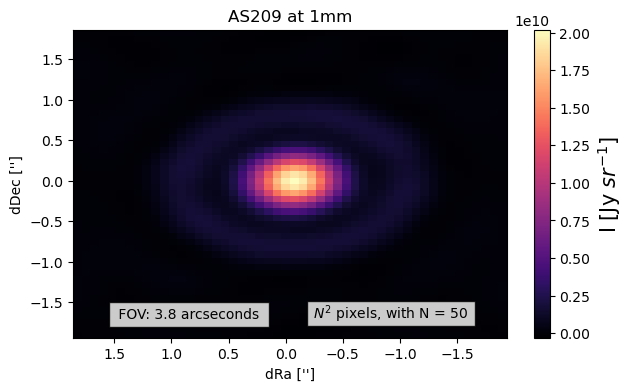

In [82]:
start_time = time.time()
x, info = cg(A, b) # M = A_precond)
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

print("CGM converged?: ", info == 0)
print("Fit well?: ", np.allclose(A.dot(x), b))
I_model =  F_inverse@ x
frank2d.sol_intensity = I_model.real.reshape(frank2d._Nx, frank2d._Ny)
Plot(frank2d).get_image('AS209 at 1mm')

### With precond

time = 0.02  min |  0.95 seconds
CGM converged?:  True
Fit well?:  False


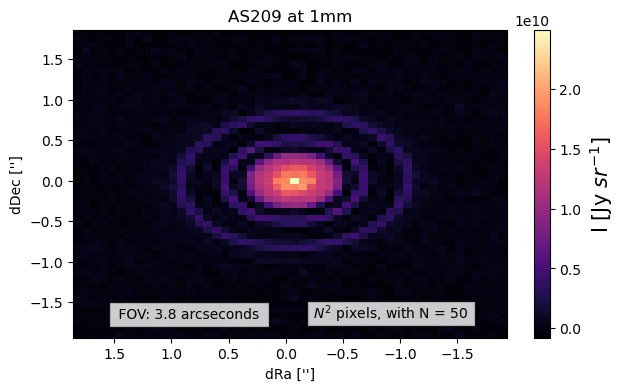

In [11]:
start_time = time.time()
x_precond, info_precond = cg(A, b, M = A_precond)

end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

print("CGM converged?: ", info_precond == 0)
print("Fit well?: ", np.allclose(A.dot(x_precond), b))
I_model_precond =  F_inverse@ x_precond
frank2d.sol_intensity = I_model_precond.real.reshape(frank2d._Nx, frank2d._Ny)
Plot(frank2d).get_image('AS209 at 1mm')

In [5]:
N = 50

In [17]:
start_time = time.time()
frank2d_1 = Frank2D(N, Rout)
frank2d_1.fit(u, v, Vis, Weights,  rtol = 1e-7) # rtol =  1e-5 default in scipy.
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Gridding...
  --> time = 0.01  min |  0.38 seconds
Fitting...
  --> time = 0.03  min |  1.51 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
Inverting...
  --> time = 0.01  min |  0.38 seconds
time = 0.07  min |  4.20 seconds


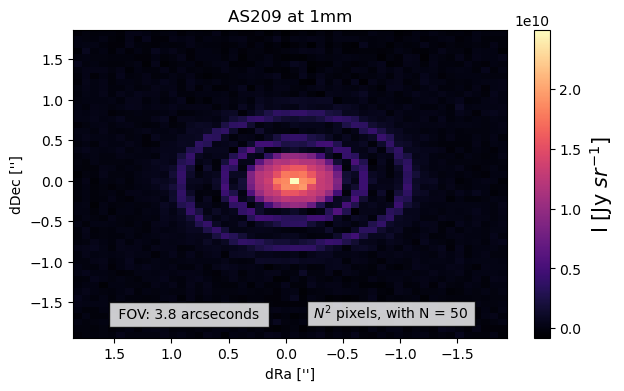

In [18]:
Plot(frank2d_1).get_image('AS209 at 1mm', log_norm = False)

#### Comparison between rtol

In [21]:
start_time = time.time()
frank2d_2 = Frank2D(N, Rout)
frank2d_2.fit(u, v, Vis, Weights, rtol = 1e-9)
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Gridding...
  --> time = 0.01  min |  0.41 seconds
Fitting...
  --> time = 0.03  min |  1.54 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
Inverting...
  --> time = 0.01  min |  0.41 seconds
time = 0.07  min |  4.34 seconds


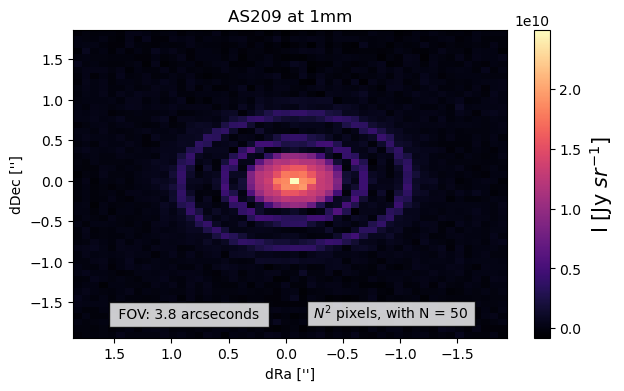

In [22]:
Plot(frank2d_2).get_image('AS209 at 1mm')

In [23]:
frank2d_3 = Frank2D(N, Rout)
frank2d_3.sol_intensity = frank2d_2.sol_intensity - frank2d_1.sol_intensity

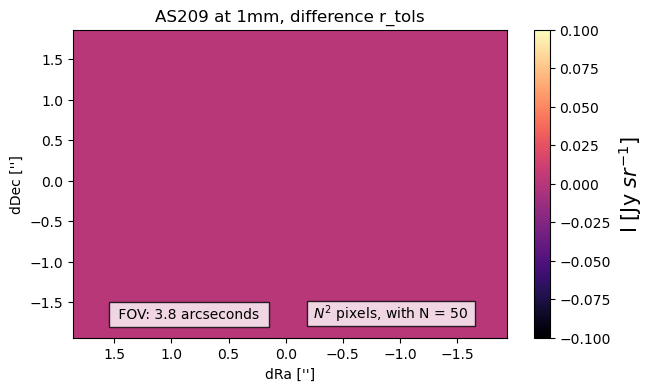

In [26]:
Plot(frank2d_3).get_image(r'AS209 at 1mm, difference r_tols', log_norm = False)

### We use $r_{tol} = 1e^{-7}$ then

In [10]:
N = 200

In [ ]:
start_time = time.time()
frank2d_0 = Frank2D(N, Rout)
frank2d_0.fit(u, v, Vis, Weights, rtol = 1e-7)
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')
Plot(frank2d_0).get_image('AS209 at 1mm')

Gridding...
  --> time = 0.01  min |  0.32 seconds
Setting kernel...
Setting fit method...
Fitting...
  *  Constructing linear operators...
     --> time = 20.01  min |  1200.65 seconds
  *  Solving linear system...
     --> time = 36.80  min |  2207.72 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
Inverting...


#### Using FFT

In [79]:
sol_int_0 = np.fft.fftshift(np.fft.ifft2(frank2d_0.sol_visibility.reshape(frank2d_0._Nx, frank2d_0._Ny)).real)/(frank2d_0._FT._dx * frank2d_0._FT._dy) 

In [81]:
sol_vis_0 = np.fft.fft2(np.fft.fftshift(frank2d_0.sol_intensity)).real*(frank2d_0._FT._dx * frank2d_0._FT._dy)

In [87]:
#plt.imshow(sol_vis_0 - frank2d_0.sol_visibility.reshape(N, N).real)
#plt.colorbar()

In [88]:
frank2d_4 = Frank2D(N, Rout)
frank2d_4.sol_intensity = sol_int_0 - frank2d_0.sol_intensity

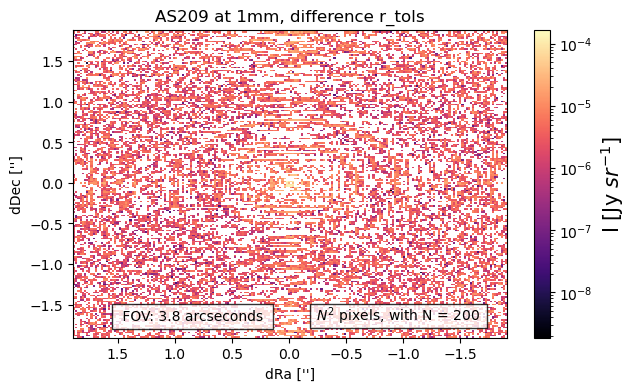

In [89]:
Plot(frank2d_4).get_image(r'AS209 at 1mm', log_norm = True)

In [5]:
N = 300
start_time = time.time()
frank2d_5 = Frank2D(N, Rout)
frank2d_5.fit(u, v, Vis, Weights, rtol = 1e-7, transform = "fft2")
end_time = time.time()
execution_time = end_time - start_time
print(f'total time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Gridding...


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:45: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.01  min |  0.33 seconds
Setting kernel...
Setting fit method...
Fitting...
  *  Constructing linear operators...
     --> time = 45.72  min |  2743.09 seconds
  *  Solving linear system...
     --> time = 35.60  min |  2136.00 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
Inverting...
  --> time = 0.00  min |  0.00 seconds
total time = 85.07  min |  5104.28 seconds


In [6]:
start_time = time.time()
np.fft.fftshift(np.fft.ifft2(frank2d_5.sol_visibility.reshape(frank2d_5._Nx, frank2d_5._Ny)).real)/(frank2d_5._FT._dx * frank2d_5._FT._dy) 
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

time = 0.00  min |  0.01 seconds


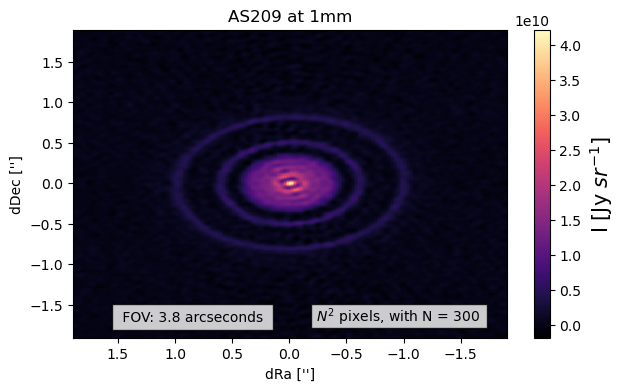

In [8]:
Plot(frank2d_5).get_image('AS209 at 1mm')

In [9]:
import pickle
name = "frank2d_300pts"
obj = frank2d_5
with open(name + ".pickle", "wb") as f:
    pickle.dump(obj, f)

## Now we try differents fit to prevent at eye the best parameters for GP (using)

In [5]:
N = 50

In [6]:
frank2d = Frank2D(N, Rout)

In [ ]:
n_plots = 9

In [17]:
np.random.seed(0)

In [18]:
c_1 = np.random.normal(60, 5, n_plots)
m_1 = np.random.normal(-5, 2, n_plots)
l_1 = np.random.normal(1e4, 1e1, n_plots)

fit : 0
Gridding...
  --> time = 0.01  min |  0.36 seconds
Setting kernel...
Setting fit method...
Fitting...
  *  Constructing linear operators...
     --> time = 0.03  min |  1.58 seconds
  *  Solving linear system...
     --> time = 0.03  min |  1.59 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
                                                 fit correctly       !!!!!!
Inverting...
  --> time = 0.00  min |  0.00 seconds
total time = 0.07  min |  3.95 seconds
 with  m = -6.2, c = 62.0, l = 1.0e+04 
.....................
fit : 1
Gridding...
  --> time = 0.01  min |  0.31 seconds
Setting kernel...
Setting fit method...
Fitting...
  *  Constructing linear operators...
     --> time = 0.02  min |  1.48 seconds
  *  Solving linear system...
     --> time = 0.01  min |  0.76 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
                                                 fit correctly       !!!!!!
Inverting...
  --> time = 0.00  min |  0.00 seconds
total t

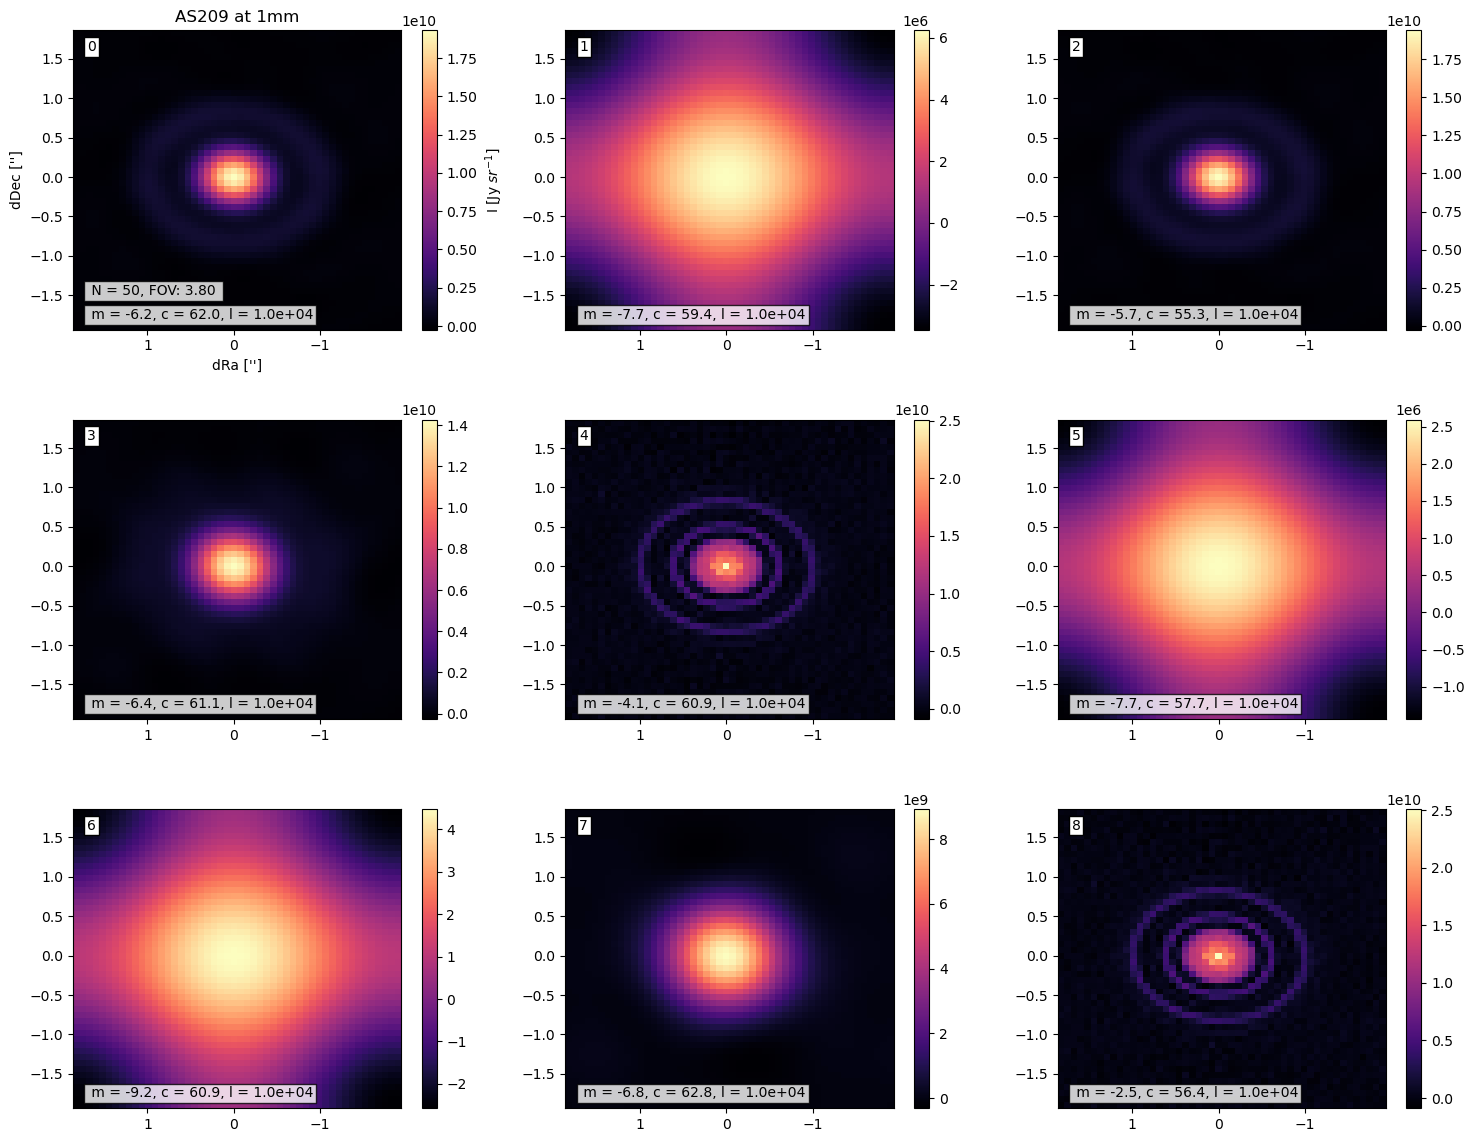

In [19]:
Vis_array_1 = Plot(frank2d).get_several_images([u, v, Vis, Weights], [m, c, l], n_plots = n_plots)

In [21]:
c_2 = np.random.normal(60, 10, n_plots)
m_2 = np.full(n_plots, -2.5)
l_2 = np.random.normal(1e4, 1e1, n_plots)

fit : 0
Gridding...
  --> time = 0.01  min |  0.36 seconds
Setting kernel...
Setting fit method...
Fitting...
  *  Constructing linear operators...
     --> time = 0.02  min |  1.49 seconds
  *  Solving linear system...
     --> time = 0.02  min |  1.47 seconds
  --> CGM converged?   True
  --> Fit correctly?   False
Inverting...
  --> time = 0.00  min |  0.00 seconds
total time = 0.06  min |  3.72 seconds
 with  m = -2.5, c = 72.3, l = 1.0e+04 
.....................
fit : 1
Gridding...
  --> time = 0.01  min |  0.31 seconds
Setting kernel...
Setting fit method...
Fitting...
  *  Constructing linear operators...
     --> time = 0.03  min |  1.56 seconds
  *  Solving linear system...
     --> time = 0.03  min |  1.52 seconds
  --> CGM converged?   True
  --> Fit correctly?   False
Inverting...
  --> time = 0.00  min |  0.00 seconds
total time = 0.06  min |  3.82 seconds
 with  m = -2.5, c = 72.0, l = 1.0e+04 
.....................
fit : 2
Gridding...
  --> time = 0.01  min |  0.31 secon

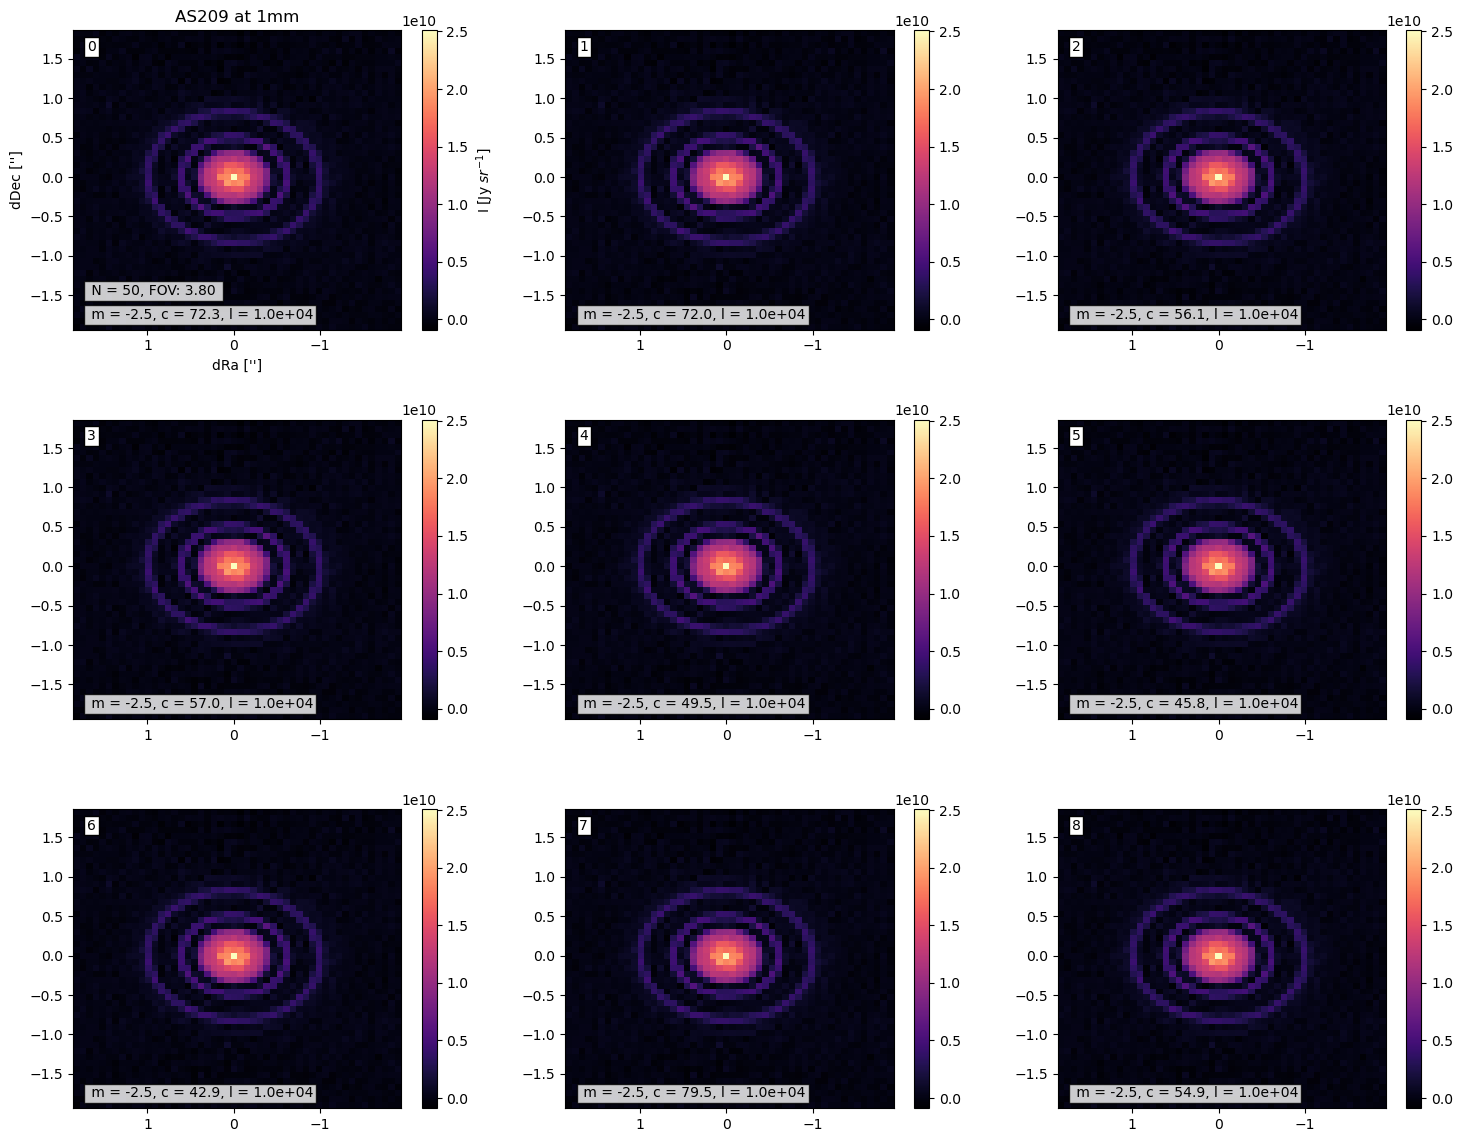

In [22]:
Vis_array_2 = Plot(frank2d).get_several_images([u, v, Vis, Weights], [m_2, c_2, l_2], n_plots = n_plots)

## Select a image and lets see its vis fit.

In [10]:
n_fit = 1

In [11]:
u_gridded, v_gridded, vis_gridded, weights_gridded = frank2d.preprocess_vis(u, v, Vis, Weights)
baseline_gridded = np.hypot(u_gridded, v_gridded)

Gridding...
  --> time = 0.01  min |  0.36 seconds


In [12]:
vis_fit = Vis_array_1[n_fit]
u_fit = frank2d._FT._Un
v_fit = frank2d._FT._Vn
baseline_fit = np.hypot(u_fit, v_fit)

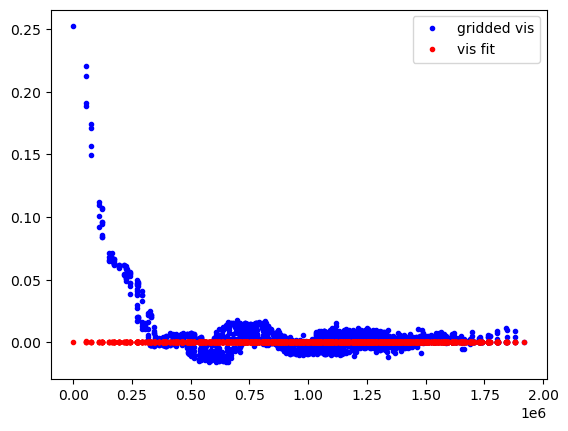

In [13]:
plt.clf()
plt.plot(baseline_gridded, vis_gridded.real, 'b', linestyle='none', marker='.', label= "gridded vis")
plt.plot(baseline_fit, vis_fit.real, 'r', linestyle='none', marker='.', label = "vis fit")
plt.legend()
plt.show()

In [16]:
#plt.clf()
#plt.plot(baseline_gridded, vis_gridded.real-vis_fit.real, 'b', linestyle='none', marker='.', label= "difference vis")
#plt.legend()
#plt.show()

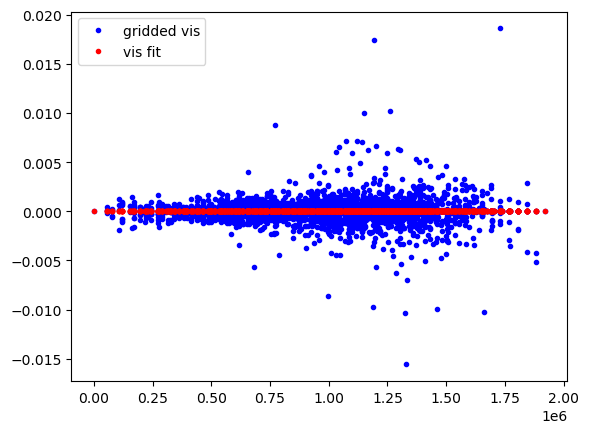

In [15]:
plt.clf()
plt.plot(baseline_gridded, vis_gridded.imag, 'b', linestyle='none', marker='.', label= "gridded vis")
plt.plot(baseline_fit, vis_fit.imag, 'r', linestyle='none', marker='.', label = "vis fit")
plt.legend()
plt.show()

## Lets recreate a particular fit

In [5]:
m = -7.2
c = 51.0
l = 1.0e+04 

In [6]:
N = 50
frank2d = Frank2D(N, Rout)

In [7]:
frank2d.fit(u, v, Vis, Weights, kernel_params = [m, c, l])

Gridding...


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:45: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.00  min |  0.27 seconds
Setting kernel...
Setting fit method...
Fitting...
  *  Constructing linear operators...
     --> time = 0.01  min |  0.90 seconds
  *  Solving linear system...
     --> time = 0.01  min |  0.49 seconds
x [3.62169493e-05-2.41598687e-09j 4.31502701e-05+1.96892035e-08j
 9.09829420e-08+9.59926730e-11j ... 1.09005131e-09-2.91980420e-12j
 2.00174804e-08-1.62733910e-10j 2.40680564e-06-6.77664106e-09j]
Ax  [3.62221457e-05-2.41633351e-09j 4.31590120e-05+1.96931924e-08j
 9.09830161e-08+9.59927510e-11j ... 1.09005133e-09-2.91980425e-12j
 2.00174846e-08-1.62733943e-10j 2.40683941e-06-6.77673613e-09j]
b  [3.62221457e-05-2.41633351e-09j 4.31590120e-05+1.96931924e-08j
 9.09830158e-08+9.59927509e-11j ... 1.09005133e-09-2.91980425e-12j
 2.00174846e-08-1.62733943e-10j 2.40683941e-06-6.77673613e-09j]
  --> CGM converged?   True
  --> Fit correctly?   True
                                                 fit correctly       !!!!!!
Inverting...
  --> time = 0.00  min

In [81]:
# Frank Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-1

In [82]:
geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)

In [83]:
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)

In [84]:
sol = FF.fit(u, v, Vis, Weights)

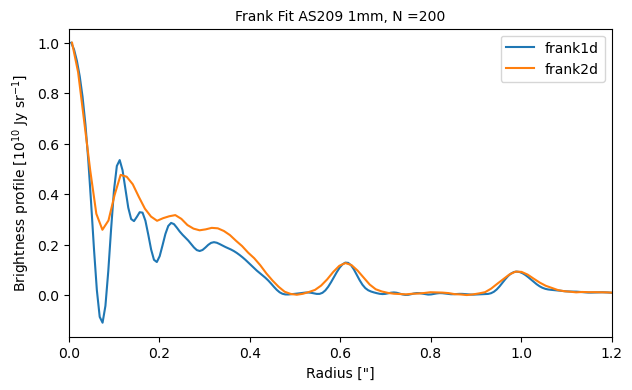

In [85]:
plt.figure(figsize = (7, 4))
plt.plot(sol.r, sol.mean/(np.max(sol.mean)),label ='frank1d')
plt.plot(r_centers, I_binned/(np.max(I_binned)), label = "frank2d")
plt.xlabel('Radius ["]', size = 10)
plt.ylabel(r'Brightness profile [$10^{10}$ Jy sr$^{-1}$]', size = 10)
plt.title('Frank Fit AS209 1mm, N =' + str(N), size = 10)
plt.xlim(0, 1.2)
plt.legend()
plt.show()

### CLEAN

In [86]:
# Obtain the radial profiles convolved to a circular beam.
from gofish import imagecube

infile_1mm = dir + 'AS209_1mm_13s_conv_circ.fits'
#2D->1D
cube_1mm = imagecube(infile_1mm)
x_1mm,y_1mm,dy_1mm = cube_1mm.radial_profile(inc=inc, PA=pa, x0=dra, y0=ddec)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


### Convolve Frank Profiles

In [87]:
from frank.utilities import convolve_profile

clean_beam_1mm = {'bmaj':0.0373, 'bmin':0.0373, 'beam_pa':31.040}
area_1mm = clean_beam_1mm['bmaj']*clean_beam_1mm['bmin']*np.pi/4./np.log(2.)*(1/rad_to_arcsec)**2

convolved_1mm_frank1d = convolve_profile(sol.r, sol.mean, inc, pa, clean_beam_1mm)*area_1mm
convolved_1mm_frank2d = convolve_profile(r_centers, I_binned, inc, pa, clean_beam_1mm)*area_1mm

### Compare profiles

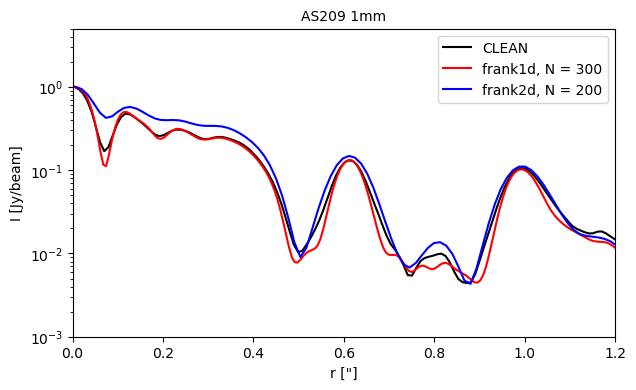

In [89]:
plt.figure(figsize=(7, 4))
plt.plot(x_1mm, y_1mm/np.max(y_1mm), "black", label = "CLEAN")
#plt.fill_between(x_1mm, y_1mm-dy_1mm, y_1mm+dy_1mm,alpha=0.7)
plt.plot(sol.r, convolved_1mm_frank1d/np.max(convolved_1mm_frank1d), "red", label=r'frank1d' + ', N = ' +str(n_pts))
plt.plot(r_centers,convolved_1mm_frank2d/np.max(convolved_1mm_frank2d), "blue", label=r'frank2d' + ', N = ' +str(N))
plt.title(r'AS209 1mm', size=10)
plt.ylabel("I [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.legend(fontsize=10)
plt.yscale('log')
plt.ylim(1e-3, 0.5e1)
plt.xlim(0,1.2)
plt.show()